In [1]:
import numpy as np
import pandas as pd
import gc
from tqdm import *
import os
import copy
import sys
import time
from collections import Counter, deque
from multiprocessing import Pool, cpu_count

import transforms3d

from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.cluster import MeanShift

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv
import open3d as o3d

import warnings
warnings.filterwarnings("ignore")

In [2]:
# %matplotlib inline
%matplotlib notebook

In [3]:
ATM_PATH = "/home/sabyasachi/Projects/ati/"
DATA_PATH = os.path.join(ATM_PATH, "data", "data", "datasets")

IISC_DATA_PATH = os.path.join(DATA_PATH, "IISC")
EXP_PATH = os.path.join(IISC_DATA_PATH, "2019-06-12","10-00-14-P1-6-auto-ccw_5loops_0.6_no_numba")

LIDAR_PCD_PATH = os.path.join(EXP_PATH, "complete_extracted")

# MAP_FILE = 'map_default_r.pcd'
# POSE_FILE = 'pose_default_r.json'

In [5]:
# FIRST_PCD = 10
# FINAL_PCD = 210
FIRST_PCD = 2
FINAL_PCD = 805

VOXEL_SZ = 0.4
# MAKE_2D = False
# APPLY_CLUSTER = False

plt.rcParams['figure.figsize'] = [7, 7]

In [6]:
def filter_pcd(old_pcd,
               apply_downsample = True,
               downsample_voxel_size = VOXEL_SZ,
               
               apply_outlier_removal = True,
               downsample_radius = 1,
               downsample_neighbors = 20,
               
               apply_crop = True,
               crop_min_arr = np.array([-100,-100,-0.5]),
               crop_max_arr = np.array([100,100,100]),
               
               apply_cluster = False,
               cluster_neighbours = 30,
               cluster_labels = 2):
    np.random.seed(0)
    pcd = copy.deepcopy(old_pcd)
    
    if apply_outlier_removal:
        denser_pcd, ind = o3d.geometry.radius_outlier_removal(pcd,
                                                              nb_points = downsample_neighbors,
                                                              radius    = downsample_radius)
        pcd = denser_pcd
    
    if apply_downsample:
        voxel_down_pcd = o3d.geometry.voxel_down_sample(pcd, voxel_size = downsample_voxel_size)
        pcd = voxel_down_pcd
    
    if apply_crop:
        cropped_pcd = o3d.geometry.crop_point_cloud(pcd, crop_min_arr, crop_max_arr)
        pcd = cropped_pcd

    if apply_cluster:
        few_pts = np.asarray(pcd.points)
        try:
            few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2).fit_transform(few_pts)
        except Exception as e:
            try:
                few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2, eigen_solver='dense').fit_transform(few_pts)
            except Exception as e:
                few_pts_reduced = few_pts
        clf = MeanShift().fit(few_pts_reduced)
        pcd.points = o3d.utility.Vector3dVector(few_pts[clf.labels_ < cluster_labels])
    
    return pcd

def make_2d(pcd):
    new_pcd = copy.deepcopy(pcd)
    new_pts = np.concatenate([np.asarray(pcd.points)[:,:-1],np.zeros((len(pcd.points),1))], axis=1)
    new_pcd.points = o3d.utility.Vector3dVector(new_pts)
    return new_pcd

def read_pcd(pcd_id):
#     prefix = "".join(["0" for _ in range(3 - len(str(pcd_id)))])
#     pcd_file = prefix + str(pcd_id) + ".pcd"
    pcd_file = str(pcd_id) + ".pcd"
    pcd = o3d.io.read_point_cloud(os.path.join(LIDAR_PCD_PATH, pcd_file))
    return pcd

def draw_pcd(pcd, where='mat_2d'):    
    if where is 'opn_nb':
        visualizer = o3d.JVisualizer()
        visualizer.add_geometry(pcd)
        visualizer.show()
    elif where is 'opn_view':
        o3d.visualization.draw_geometries([pcd], width=1280, height=800)
    elif where is 'mat_3d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], pts[:,2])
        plt.show()
    elif where is 'mat_2d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], s=1)
        plt.show()
        
def draw_registration_result(src_pcd, dst_pcd, x_pt, y_pt, theta):    
    src_pcd_tmp = copy.deepcopy(src_pcd)
    dst_pcd_tmp = copy.deepcopy(dst_pcd)
    
    src_pcd_tmp.paint_uniform_color([1, 0, 0])  # red source
    dst_pcd_tmp.paint_uniform_color([0, 0, 1])  # blue target
    
    transform_mat = pose2matrix([x_pt, y_pt, 0], [0,0,theta])
    dst_pcd_tmp.transform(transform_mat)
    
    visualizer = o3d.JVisualizer()
    visualizer.add_geometry(src_pcd_tmp)
    visualizer.add_geometry(dst_pcd_tmp)
    visualizer.show()

<IPython.core.display.Javascript object>


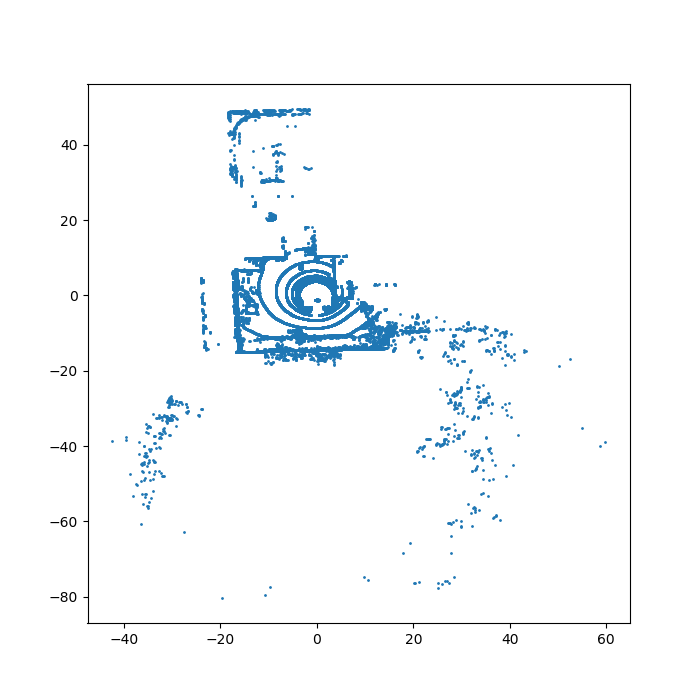

geometry::PointCloud with 26427 points.

In [7]:
some_pcd = read_pcd(350)
draw_pcd(some_pcd)
some_pcd

<IPython.core.display.Javascript object>


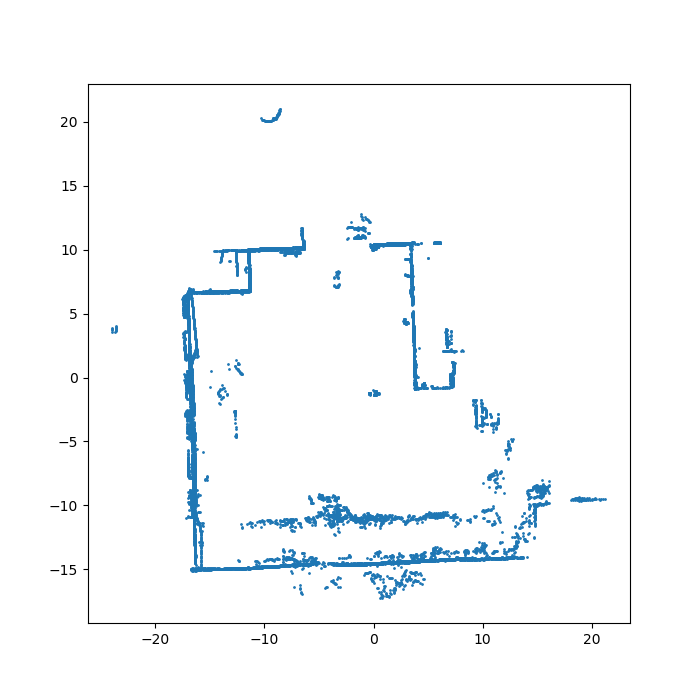

geometry::PointCloud with 13144 points.

In [8]:
some_pcd = filter_pcd(some_pcd,
                      apply_downsample = False,
                      apply_outlier_removal = True,
                      apply_crop = True,
                      apply_cluster = False)
draw_pcd(some_pcd)
some_pcd

<IPython.core.display.Javascript object>


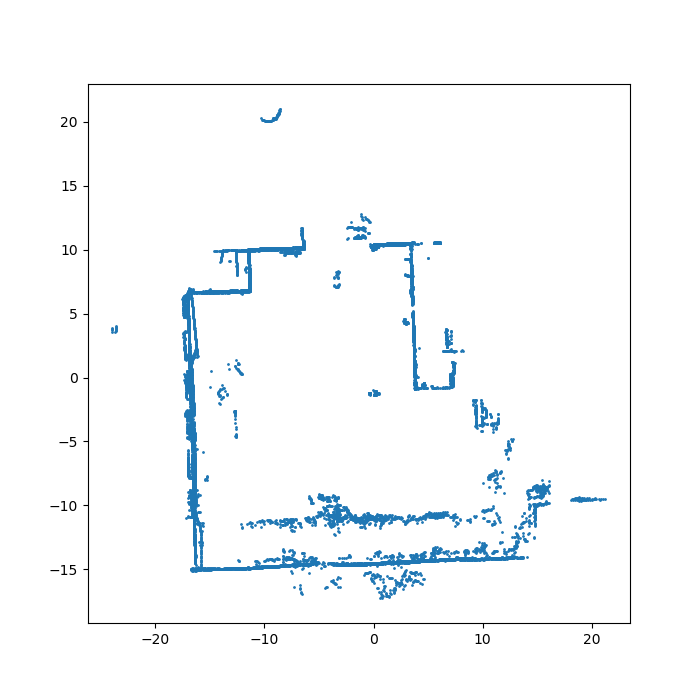

geometry::PointCloud with 13144 points.

In [9]:
some_pcd = make_2d(some_pcd)
draw_pcd(some_pcd)
some_pcd

<IPython.core.display.Javascript object>


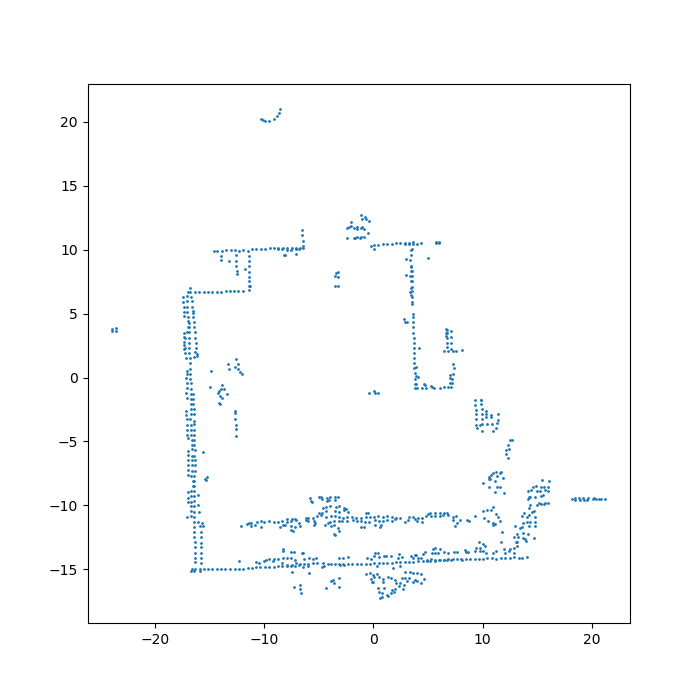

geometry::PointCloud with 914 points.

In [10]:
for _ in range(3):
    some_pcd = filter_pcd(some_pcd,
                          apply_downsample = True,
                          apply_outlier_removal = False,
                          apply_crop = False,
                          apply_cluster = False)
draw_pcd(some_pcd)
some_pcd

In [ ]:
arr = np.load("../Baselines/DeepMapping/script/full_arr.npy", allow_pickle=True)

In [ ]:
max([something.shape[0] for something in arr])

In [ ]:
new_size = 2100
np.random.seed(0)

for curr_pts in arr:
    old_size = curr_pts.shape[0]
    delta = new_size - old_size
    idx_list = np.random.randint(low=0, high=old_size, size=delta)
    delta_pts = np.array([curr_pts[idx] for idx in idx_list])
    new_pts = np.concatenate([curr_pts, delta_pts])

In [ ]:
            old_size = current_point_cloud.shape[0]
            delta_size = NEW_SIZE - old_size
            idx_list = np.random.randint(low=0, high=old_size, size=delta_size)
            delta_point_cloud = np.array([current_point_cloud[idx] for idx in idx_list])
            current_point_cloud = np.concatenate([current_point_cloud, delta_point_cloud])

In [ ]:
new_pts.shape

In [ ]:
len(set([(x,y) for x, y in new_pts]))

In [ ]:
old_size